In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
%matplotlib inline

print("Libraries imported successfully!")

In [ ]:
# Load the data
def load_and_profile_data(filepath):
    """
    Load dataset and perform initial profiling
    """
    df = pd.read_csv(filepath)
    
    print("="*50)
    print("DATA PROFILE REPORT")
    print("="*50)
    
    # Basic info
    print(f"Dataset Shape: {df.shape}")
    print(f"\nColumns: {list(df.columns)}")
    print(f"\nData Types:")
    print(df.dtypes)
    
    # Check for timestamp column
    timestamp_cols = [col for col in df.columns if 'time' in col.lower() or 'date' in col.lower()]
    if timestamp_cols:
        print(f"\nTimestamp columns found: {timestamp_cols}")
    
    return df

# Load your data - CALL the function with the filepath
df = load_and_profile_data('../data/sierraleone-bumbuna.csv')  # Adjust path as needed

In [4]:
def comprehensive_summary(df):
    """
    Generate comprehensive summary statistics and missing value report
    """
    print("="*50)
    print("SUMMARY STATISTICS")
    print("="*50)
    
    # Numeric columns summary
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    print("Numeric Columns Summary:")
    print(df[numeric_cols].describe())
    
    print("\n" + "="*50)
    print("MISSING VALUE REPORT")
    print("="*50)
    
    # Missing value analysis
    missing_report = pd.DataFrame({
        'Missing_Count': df.isnull().sum(),
        'Missing_Percentage': (df.isnull().sum() / len(df)) * 100
    })
    print(missing_report)
    
    # Columns with >5% missing values
    high_missing = missing_report[missing_report['Missing_Percentage'] > 5]
    if not high_missing.empty:
        print(f"\nColumns with >5% missing values:")
        print(high_missing)
    else:
        print("\nNo columns with >5% missing values")
    
    return numeric_cols

numeric_columns = comprehensive_summary(df)

SUMMARY STATISTICS
Numeric Columns Summary:
                 GHI            DNI            DHI           ModA  \
count  525600.000000  525600.000000  525600.000000  525600.000000   
mean      201.957515     116.376337     113.720571     206.643095   
std       298.495150     218.652659     158.946032     300.896893   
min       -19.500000      -7.800000     -17.900000       0.000000   
25%        -2.800000      -0.300000      -3.800000       0.000000   
50%         0.300000      -0.100000      -0.100000       3.600000   
75%       362.400000     107.000000     224.700000     359.500000   
max      1499.000000     946.000000     892.000000    1507.000000   

                ModB           Tamb             RH             WS  \
count  525600.000000  525600.000000  525600.000000  525600.000000   
mean      198.114691      26.319394      79.448857       1.146113   
std       288.889073       4.398605      20.520775       1.239248   
min         0.000000      12.300000       9.900000       0

In [5]:
def detect_outliers(df, numeric_cols):
    """
    Detect outliers using Z-score method and perform basic cleaning
    """
    print("="*50)
    print("OUTLIER DETECTION REPORT")
    print("="*50)
    
    # Key columns for solar analysis
    key_columns = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust']
    available_key_cols = [col for col in key_columns if col in df.columns]
    
    outlier_report = {}
    
    for col in available_key_cols:
        if col in numeric_cols:
            # Calculate Z-scores
            z_scores = np.abs(stats.zscore(df[col].dropna()))
            outlier_count = len(z_scores[z_scores > 3])
            outlier_percentage = (outlier_count / len(z_scores)) * 100
            
            outlier_report[col] = {
                'outlier_count': outlier_count,
                'outlier_percentage': outlier_percentage
            }
            
            print(f"{col}: {outlier_count} outliers ({outlier_percentage:.2f}%)")
    
    return outlier_report, available_key_cols

outlier_report, key_cols = detect_outliers(df, numeric_columns)

OUTLIER DETECTION REPORT
GHI: 2477 outliers (0.47%)
DNI: 7586 outliers (1.44%)
DHI: 2986 outliers (0.57%)
ModA: 1604 outliers (0.31%)
ModB: 2041 outliers (0.39%)
WS: 3967 outliers (0.75%)
WSgust: 3665 outliers (0.70%)


In [6]:
def clean_data(df, key_cols):
    """
    Clean the dataset: handle missing values and outliers
    """
    df_clean = df.copy()
    
    print("="*50)
    print("DATA CLEANING PROCESS")
    print("="*50)
    
    # Handle missing values in key columns (impute with median)
    for col in key_cols:
        if col in df_clean.columns:
            missing_before = df_clean[col].isnull().sum()
            if missing_before > 0:
                df_clean[col].fillna(df_clean[col].median(), inplace=True)
                print(f"Imputed {missing_before} missing values in {col} with median")
    
    # Handle outliers using IQR method (more robust than Z-score for skewed data)
    for col in key_cols:
        if col in df_clean.columns:
            Q1 = df_clean[col].quantile(0.25)
            Q3 = df_clean[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            
            outliers_before = len(df_clean[(df_clean[col] < lower_bound) | (df_clean[col] > upper_bound)])
            
            # Cap outliers instead of removing to preserve data structure
            df_clean[col] = np.where(df_clean[col] < lower_bound, lower_bound, df_clean[col])
            df_clean[col] = np.where(df_clean[col] > upper_bound, upper_bound, df_clean[col])
            
            print(f"Capped {outliers_before} outliers in {col}")
    
    print(f"\nOriginal data shape: {df.shape}")
    print(f"Cleaned data shape: {df_clean.shape}")
    
    return df_clean

df_clean = clean_data(df, key_cols)

DATA CLEANING PROCESS
Capped 15853 outliers in GHI
Capped 101688 outliers in DNI
Capped 4407 outliers in DHI
Capped 21017 outliers in ModA
Capped 20613 outliers in ModB
Capped 3169 outliers in WS
Capped 3665 outliers in WSgust

Original data shape: (525600, 19)
Cleaned data shape: (525600, 19)


TIME SERIES ANALYSIS


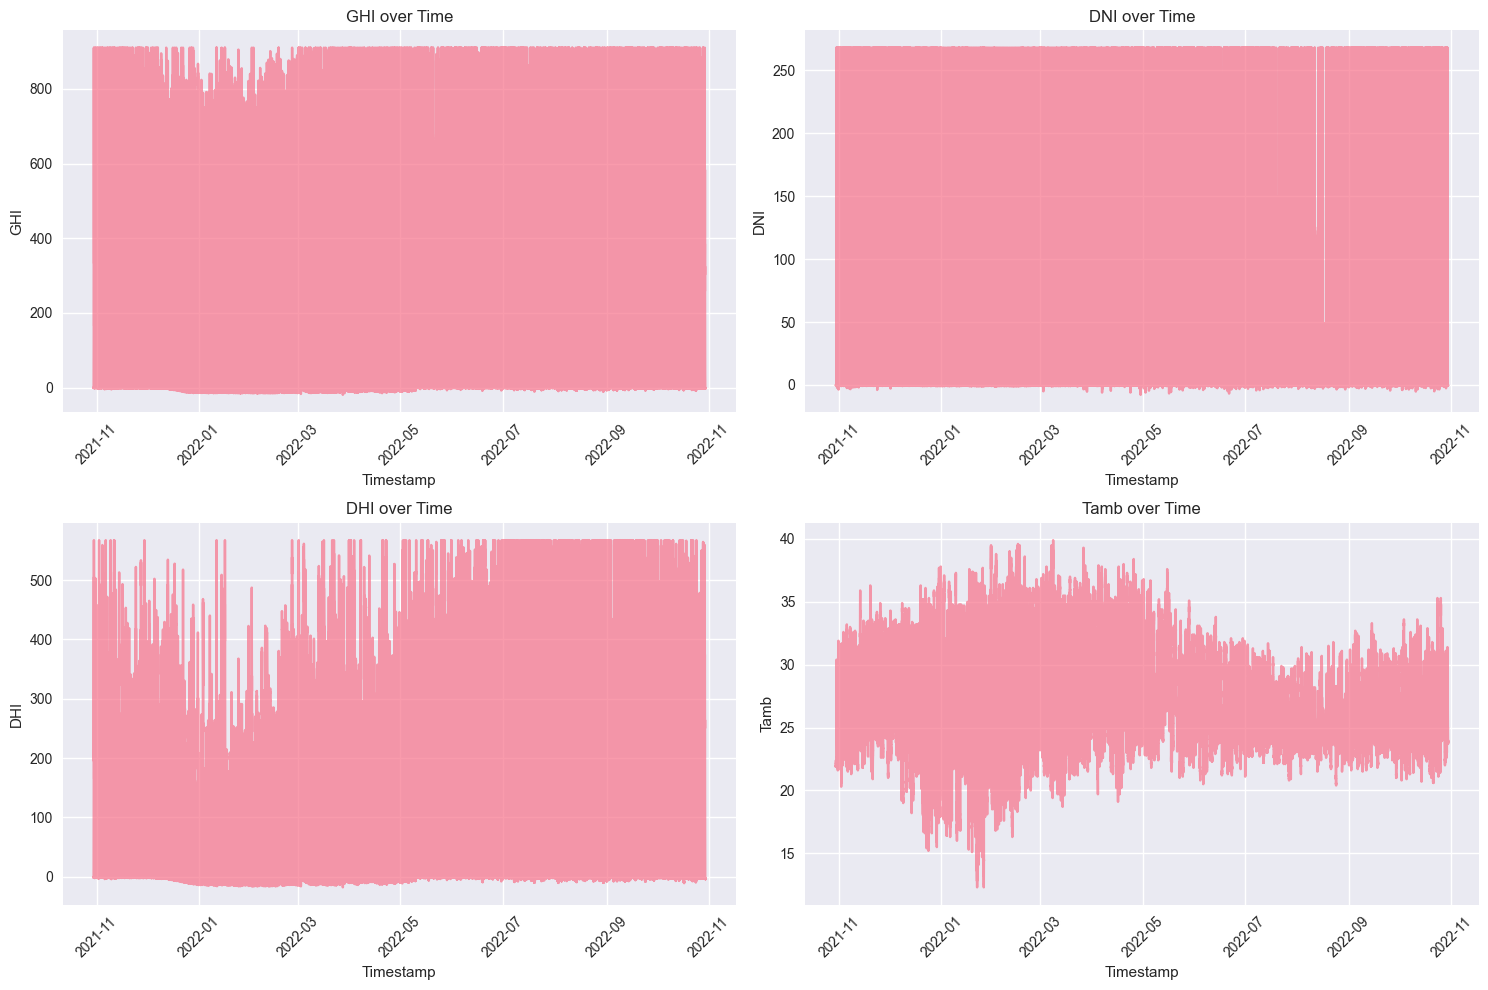

In [7]:
def time_series_analysis(df_clean):
    """
    Perform time series analysis on solar radiation data
    """
    print("="*50)
    print("TIME SERIES ANALYSIS")
    print("="*50)
    
    # Identify timestamp column (you'll need to adjust this based on your data)
    timestamp_col = None
    for col in df_clean.columns:
        if 'time' in col.lower() or 'date' in col.lower():
            timestamp_col = col
            break
    
    if timestamp_col:
        # Convert to datetime if possible
        try:
            df_clean[timestamp_col] = pd.to_datetime(df_clean[timestamp_col])
            df_clean = df_clean.sort_values(timestamp_col)
            
            # Create time-based features
            df_clean['hour'] = df_clean[timestamp_col].dt.hour
            df_clean['month'] = df_clean[timestamp_col].dt.month
            df_clean['day_of_year'] = df_clean[timestamp_col].dt.dayofyear
            
        except:
            print(f"Could not convert {timestamp_col} to datetime")
            timestamp_col = None
    
    # Plot key solar metrics over time
    solar_metrics = ['GHI', 'DNI', 'DHI', 'Tamb']
    available_metrics = [metric for metric in solar_metrics if metric in df_clean.columns]
    
    if available_metrics and timestamp_col:
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        axes = axes.ravel()
        
        for i, metric in enumerate(available_metrics[:4]):
            axes[i].plot(df_clean[timestamp_col], df_clean[metric], alpha=0.7)
            axes[i].set_title(f'{metric} over Time')
            axes[i].set_xlabel('Timestamp')
            axes[i].set_ylabel(metric)
            axes[i].tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        plt.show()
    
    return df_clean, timestamp_col

df_clean, timestamp_col = time_series_analysis(df_clean)

CLEANING IMPACT ANALYSIS


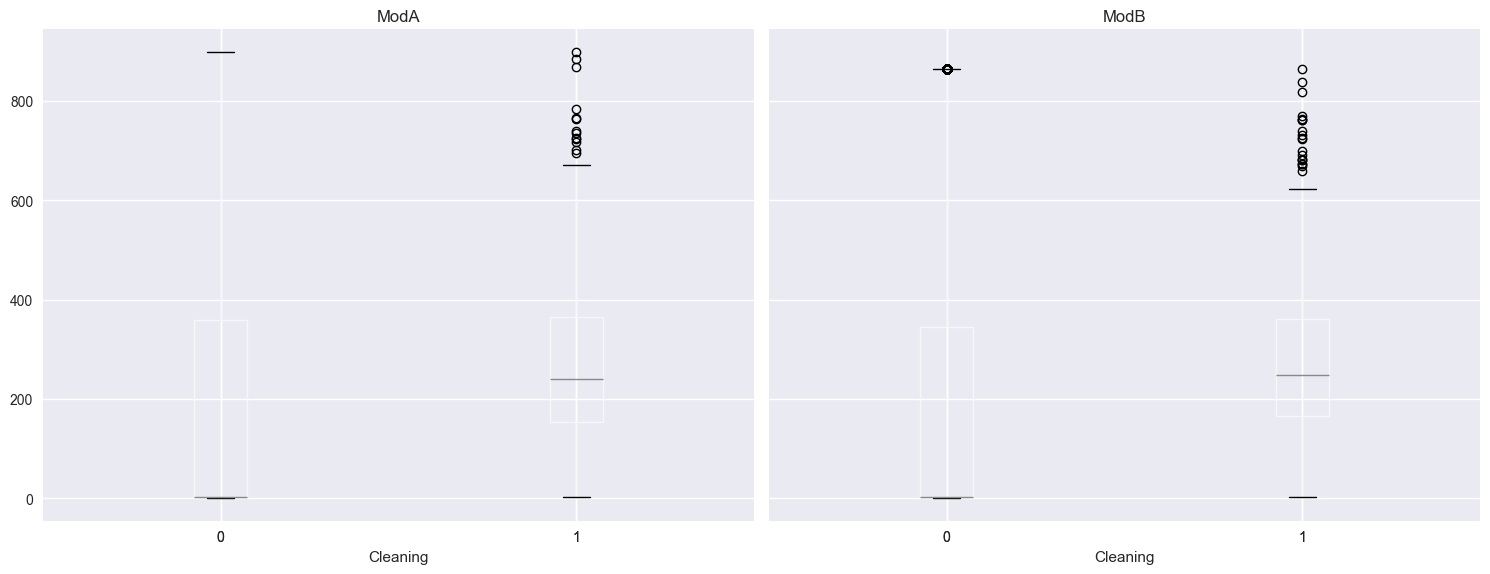

T-test for ModA difference: t-stat=-5.387, p-value=0.000


In [8]:
def cleaning_impact_analysis(df_clean):
    """
    Analyze the impact of cleaning events on sensor readings
    """
    print("="*50)
    print("CLEANING IMPACT ANALYSIS")
    print("="*50)
    
    # Check if cleaning flag exists
    cleaning_flags = [col for col in df_clean.columns if 'clean' in col.lower()]
    
    if cleaning_flags and 'ModA' in df_clean.columns and 'ModB' in df_clean.columns:
        cleaning_col = cleaning_flags[0]
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        # Group by cleaning flag and plot average sensor readings
        cleaning_groups = df_clean.groupby(cleaning_col)[['ModA', 'ModB']].mean()
        
        cleaning_groups.plot(kind='bar', ax=ax1)
        ax1.set_title('Average Sensor Readings by Cleaning Event')
        ax1.set_ylabel('Sensor Reading')
        ax1.tick_params(axis='x', rotation=45)
        
        # Box plot to show distribution
        df_clean.boxplot(column=['ModA', 'ModB'], by=cleaning_col, ax=ax2)
        ax2.set_title('Sensor Readings Distribution by Cleaning Event')
        
        plt.suptitle('')
        plt.tight_layout()
        plt.show()
        
        # Statistical test for significance
        from scipy.stats import ttest_ind
        
        clean_events = df_clean[cleaning_col].unique()
        if len(clean_events) == 2:
            group1 = df_clean[df_clean[cleaning_col] == clean_events[0]]['ModA']
            group2 = df_clean[df_clean[cleaning_col] == clean_events[1]]['ModA']
            
            t_stat, p_value = ttest_ind(group1, group2, nan_policy='omit')
            print(f"T-test for ModA difference: t-stat={t_stat:.3f}, p-value={p_value:.3f}")
    
    else:
        print("Cleaning flag or sensor data not available for analysis")

cleaning_impact_analysis(df_clean)

CORRELATION ANALYSIS


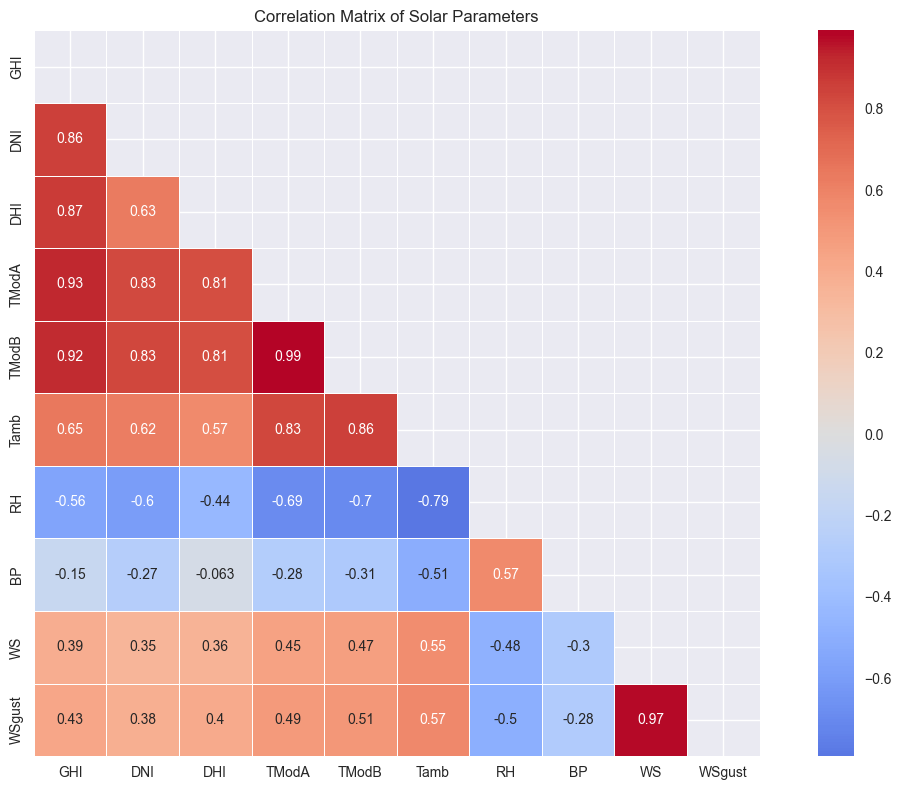

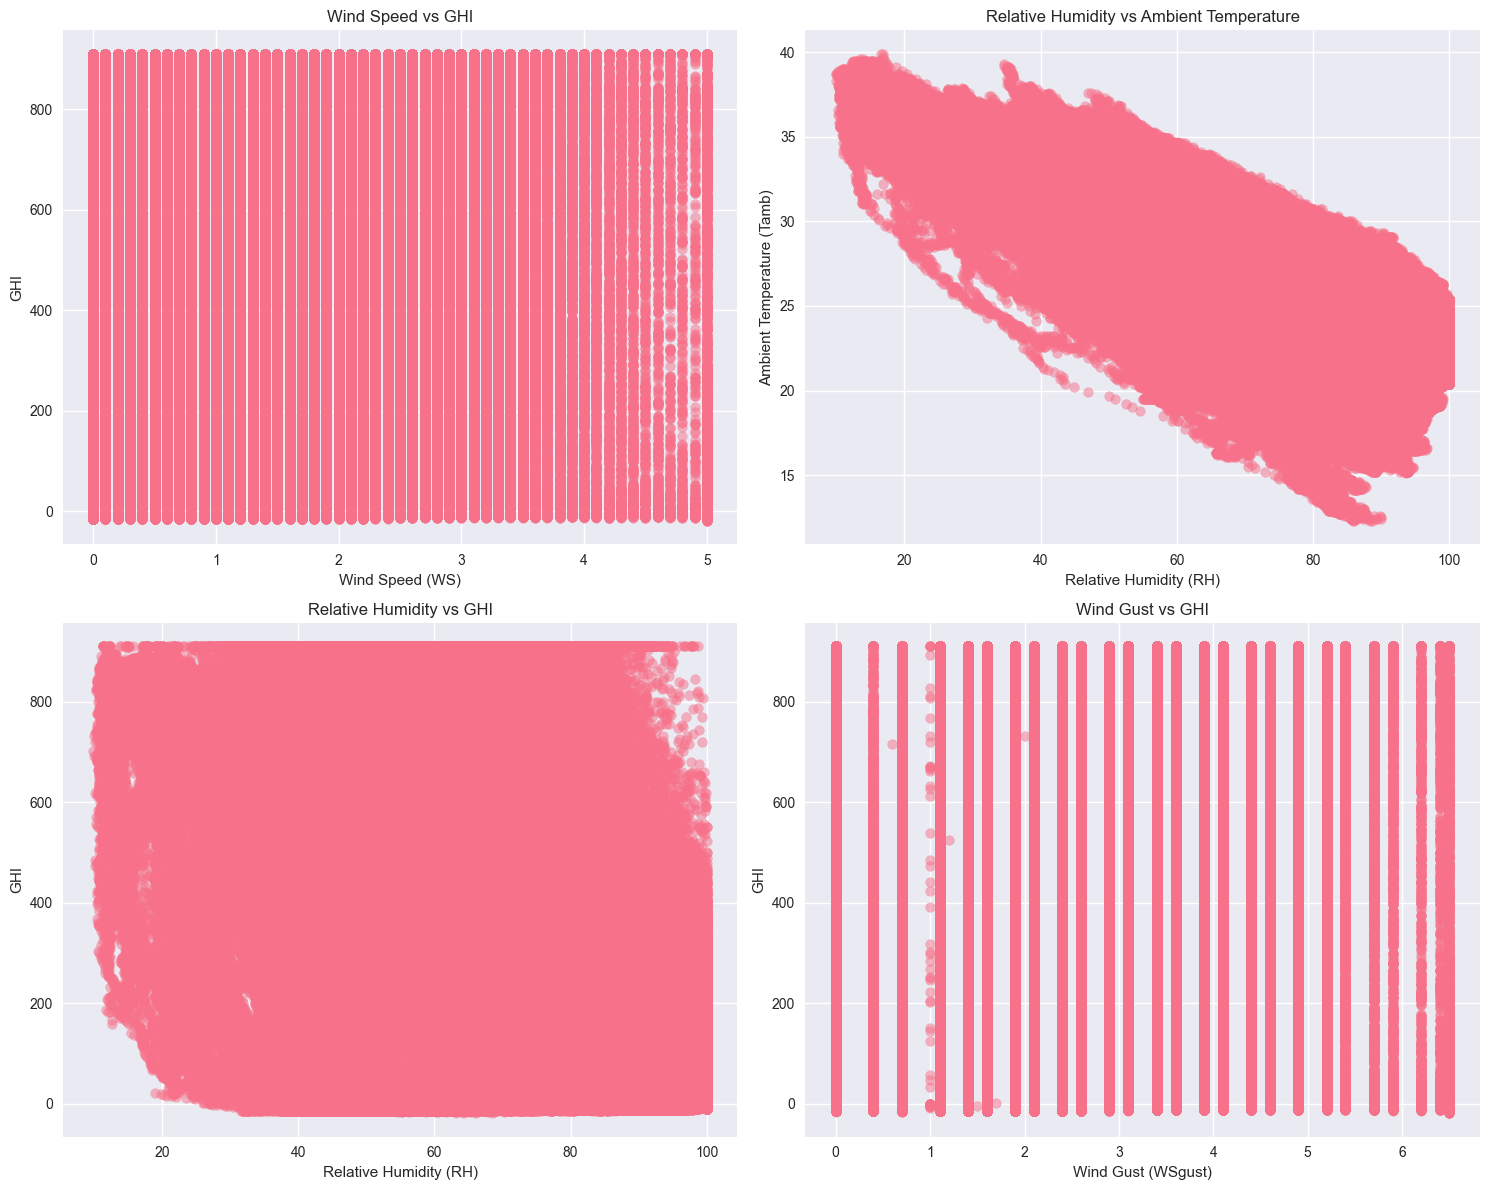

In [9]:
def correlation_analysis(df_clean):
    """
    Perform correlation analysis and relationship visualization
    """
    print("="*50)
    print("CORRELATION ANALYSIS")
    print("="*50)
    
    # Select key columns for correlation analysis
    correlation_cols = ['GHI', 'DNI', 'DHI', 'TModA', 'TModB', 'Tamb', 'RH', 'BP', 'WS', 'WSgust']
    available_corr_cols = [col for col in correlation_cols if col in df_clean.columns]
    
    if len(available_corr_cols) > 1:
        # Correlation heatmap
        plt.figure(figsize=(12, 8))
        corr_matrix = df_clean[available_corr_cols].corr()
        mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
        sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', center=0,
                   square=True, linewidths=0.5)
        plt.title('Correlation Matrix of Solar Parameters')
        plt.tight_layout()
        plt.show()
        
        # Scatter plots for key relationships
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        
        # WS vs GHI
        if 'WS' in df_clean.columns and 'GHI' in df_clean.columns:
            axes[0,0].scatter(df_clean['WS'], df_clean['GHI'], alpha=0.5)
            axes[0,0].set_xlabel('Wind Speed (WS)')
            axes[0,0].set_ylabel('GHI')
            axes[0,0].set_title('Wind Speed vs GHI')
        
        # RH vs Tamb
        if 'RH' in df_clean.columns and 'Tamb' in df_clean.columns:
            axes[0,1].scatter(df_clean['RH'], df_clean['Tamb'], alpha=0.5)
            axes[0,1].set_xlabel('Relative Humidity (RH)')
            axes[0,1].set_ylabel('Ambient Temperature (Tamb)')
            axes[0,1].set_title('Relative Humidity vs Ambient Temperature')
        
        # RH vs GHI
        if 'RH' in df_clean.columns and 'GHI' in df_clean.columns:
            axes[1,0].scatter(df_clean['RH'], df_clean['GHI'], alpha=0.5)
            axes[1,0].set_xlabel('Relative Humidity (RH)')
            axes[1,0].set_ylabel('GHI')
            axes[1,0].set_title('Relative Humidity vs GHI')
        
        # WSgust vs GHI
        if 'WSgust' in df_clean.columns and 'GHI' in df_clean.columns:
            axes[1,1].scatter(df_clean['WSgust'], df_clean['GHI'], alpha=0.5)
            axes[1,1].set_xlabel('Wind Gust (WSgust)')
            axes[1,1].set_ylabel('GHI')
            axes[1,1].set_title('Wind Gust vs GHI')
        
        plt.tight_layout()
        plt.show()

correlation_analysis(df_clean)

WIND ANALYSIS


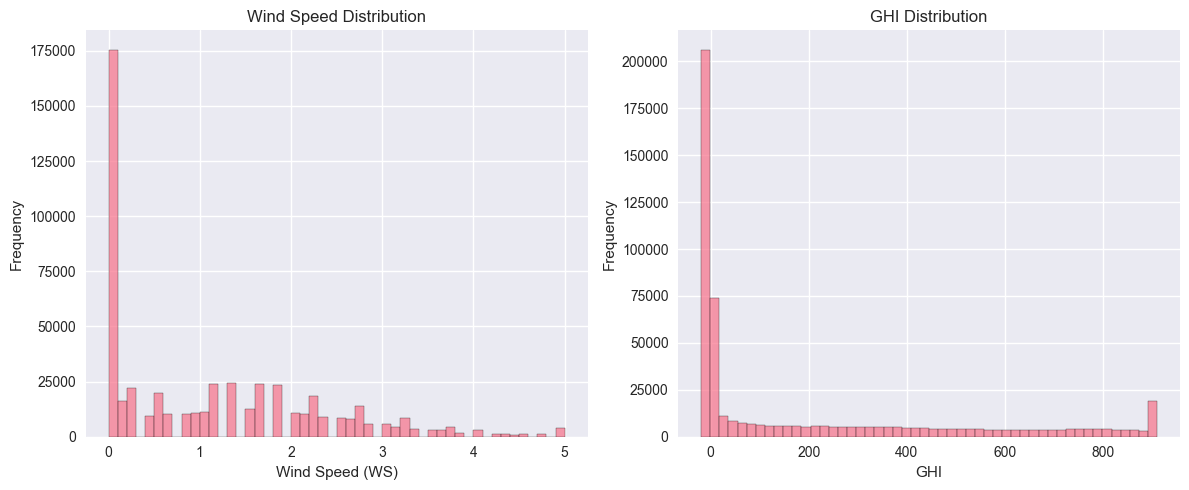

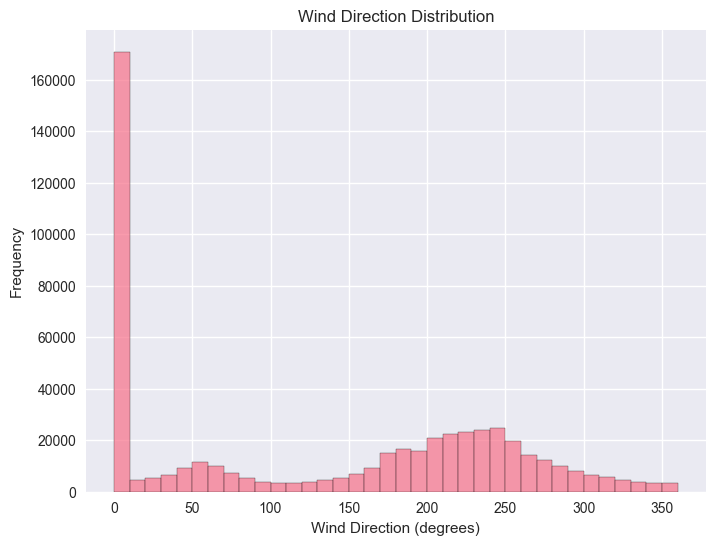

In [10]:
def wind_analysis(df_clean):
    """
    Analyze wind patterns and distributions
    """
    print("="*50)
    print("WIND ANALYSIS")
    print("="*50)
    
    # Wind speed distribution
    if 'WS' in df_clean.columns:
        plt.figure(figsize=(12, 5))
        
        plt.subplot(1, 2, 1)
        plt.hist(df_clean['WS'].dropna(), bins=50, alpha=0.7, edgecolor='black')
        plt.xlabel('Wind Speed (WS)')
        plt.ylabel('Frequency')
        plt.title('Wind Speed Distribution')
        
        # GHI distribution
        plt.subplot(1, 2, 2)
        plt.hist(df_clean['GHI'].dropna(), bins=50, alpha=0.7, edgecolor='black')
        plt.xlabel('GHI')
        plt.ylabel('Frequency')
        plt.title('GHI Distribution')
        
        plt.tight_layout()
        plt.show()
    
    # Basic wind direction analysis (if available)
    if 'WD' in df_clean.columns:
        plt.figure(figsize=(8, 6))
        plt.hist(df_clean['WD'].dropna(), bins=36, alpha=0.7, edgecolor='black')
        plt.xlabel('Wind Direction (degrees)')
        plt.ylabel('Frequency')
        plt.title('Wind Direction Distribution')
        plt.show()

wind_analysis(df_clean)

TEMPERATURE & HUMIDITY ANALYSIS


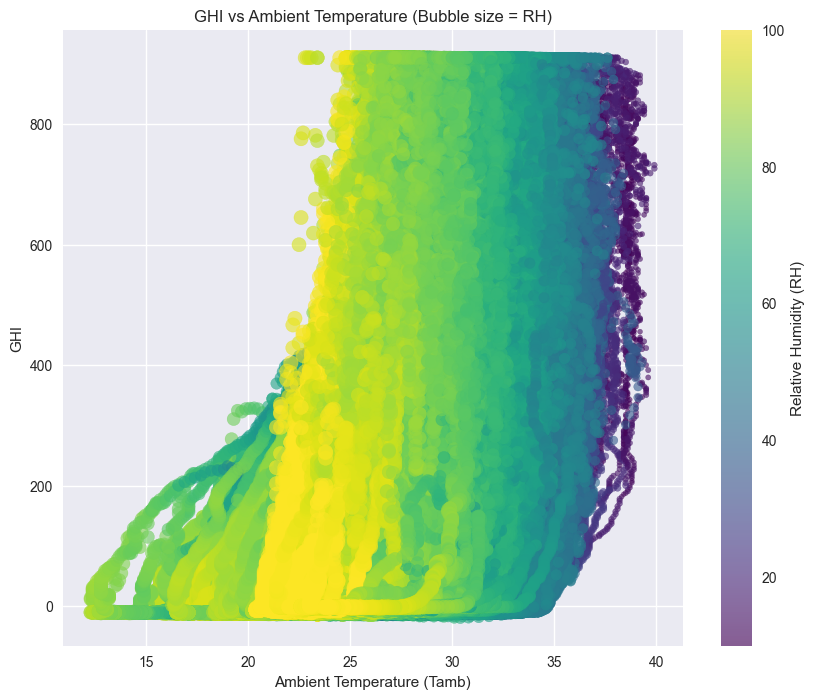

Correlation between RH and Tamb: -0.792


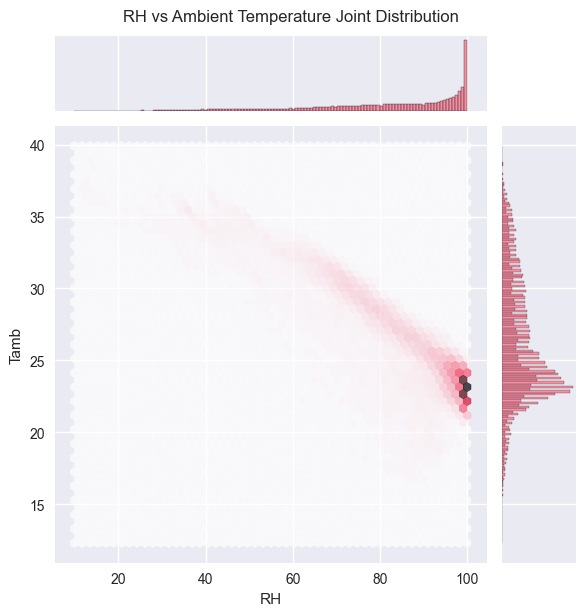

In [11]:
def temperature_analysis(df_clean):
    """
    Analyze temperature patterns and relationships with humidity
    """
    print("="*50)
    print("TEMPERATURE & HUMIDITY ANALYSIS")
    print("="*50)
    
    # Bubble chart: GHI vs Tamb with bubble size = RH
    if all(col in df_clean.columns for col in ['GHI', 'Tamb', 'RH']):
        plt.figure(figsize=(10, 8))
        
        # Normalize RH for bubble sizes
        rh_normalized = (df_clean['RH'] - df_clean['RH'].min()) / (df_clean['RH'].max() - df_clean['RH'].min())
        bubble_sizes = rh_normalized * 100 + 10  # Scale for visibility
        
        scatter = plt.scatter(df_clean['Tamb'], df_clean['GHI'], 
                            s=bubble_sizes, alpha=0.6, c=df_clean['RH'], cmap='viridis')
        
        plt.colorbar(scatter, label='Relative Humidity (RH)')
        plt.xlabel('Ambient Temperature (Tamb)')
        plt.ylabel('GHI')
        plt.title('GHI vs Ambient Temperature (Bubble size = RH)')
        plt.show()
    
    # RH vs Temperature relationship
    if all(col in df_clean.columns for col in ['RH', 'Tamb']):
        # Calculate correlation
        corr = df_clean['RH'].corr(df_clean['Tamb'])
        print(f"Correlation between RH and Tamb: {corr:.3f}")
        
        # Create joint plot
        sns.jointplot(x='RH', y='Tamb', data=df_clean, kind='hex', alpha=0.7)
        plt.suptitle('RH vs Ambient Temperature Joint Distribution', y=1.02)
        plt.show()

temperature_analysis(df_clean)

In [13]:
def export_clean_data(df_clean, country_name):
    """
    Export cleaned dataset and generate summary report
    """
    # Export to CSV (make sure data/ is in .gitignore)
    output_path = f'../data/{country_name}_clean.csv'
    df_clean.to_csv(output_path, index=False)
    print(f"Cleaned data exported to: {output_path}")
    
    # Generate summary report
    print("\n" + "="*50)
    print("CLEANING SUMMARY REPORT")
    print("="*50)
    print(f"Original dataset shape: {df.shape}")
    print(f"Cleaned dataset shape: {df_clean.shape}")
    print(f"Columns processed: {len(df_clean.columns)}")
    print(f"Total rows: {len(df_clean)}")
    
    # Check data quality after cleaning
    print("\nData Quality After Cleaning:")
    print(f"Missing values in key columns:")
    for col in key_cols:
        if col in df_clean.columns:
            missing = df_clean[col].isnull().sum()
            print(f"  {col}: {missing} missing ({missing/len(df_clean)*100:.2f}%)")

# Export the cleaned data
export_clean_data(df_clean, 'sierra_leone')

Cleaned data exported to: ../data/sierra_leone_clean.csv

CLEANING SUMMARY REPORT
Original dataset shape: (525600, 19)
Cleaned dataset shape: (525600, 22)
Columns processed: 22
Total rows: 525600

Data Quality After Cleaning:
Missing values in key columns:
  GHI: 0 missing (0.00%)
  DNI: 0 missing (0.00%)
  DHI: 0 missing (0.00%)
  ModA: 0 missing (0.00%)
  ModB: 0 missing (0.00%)
  WS: 0 missing (0.00%)
  WSgust: 0 missing (0.00%)
